<a href="https://colab.research.google.com/github/entc-17-fyp-20/CM_Normal_Behaviour_Modeling/blob/akeshala/CNN1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Generator bearing temperature** as target

# Import libraries and datasets

In [48]:
# multivariate data preparation
from numpy import array
from numpy import hstack
import pandas as pd
import numpy as np
from sklearn import preprocessing
from datetime import datetime

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten, BatchNormalization, Dropout
from keras.layers.convolutional import Conv1D
from keras.callbacks import EarlyStopping, ModelCheckpoint

import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [36]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [37]:
#@title Select Dataset New { display-mode: "form" }
turbine = 'T01' #@param ["T01", "T02","T03","T22","T34","T54"]
path = '/content/drive/MyDrive/IIoT - Wind Turbine/FYP/Dataset/Merged/' + turbine + '.csv'
df = pd.read_csv(path)

In [38]:
n_steps = 144 #one day

In [39]:
#@title Select scaling method { display-mode: "form" }
method = 'MinMax' #@param ["Normalize", "MinMax"]

df_time = df["Date_Time"]
df.drop("Date_Time", axis='columns', inplace=True)
column_names = df.columns

if method == "Normalize":
  d = preprocessing.normalize(df, axis=0)
else:
  scaler = preprocessing.MinMaxScaler()
  d = scaler.fit_transform(df)

df = pd.DataFrame(d, columns=column_names)
df["Date_Time"] = df_time
df = df.set_index(df['Date_Time'])

In [40]:
n_features = 4

format = '%Y-%m-%d %H:%M:%S'
split_index=[];
split_index.append(df['Date_Time'][0])
for i in range(0,len(df['Date_Time'])-1):
  current_time =  df['Date_Time'][i]
  following_time=  df['Date_Time'][i+1]
  time_gap =datetime.strptime(following_time, format)-datetime.strptime(current_time, format)
  if (time_gap.seconds > 600*5):
    split_index.append(current_time)
    split_index.append(following_time)
split_index.append(df['Date_Time'][len(df['Date_Time'])-1])

df = df.set_index(df['Date_Time'])

In [41]:
X_concat_train, y_concat_train, y_concat_test, X_concat_test = [],[],[],[]

for i in range(0,len(split_index),2):
  dfx = df[split_index[i]:split_index[i+1]]
  if len(dfx)>=144:
    dfx = dfx[['Active_Power','Ambient_Temperature','Wind_Speed','Generator_RPM','Generator_Bearing_Tempeature']]
    dfx = dfx.to_numpy()
    # convert into input/output
    X, y = split_sequences(dfx, n_steps)
    if i<len(split_index)*0.8:
      X_concat_train.append(X)
      y_concat_train.append(y)
    else:
      X_concat_test.append(X)
      y_concat_test.append(y)

X_concat_train = tuple(X_concat_train)
y_concat_train = tuple(y_concat_train)

X_concat_test = tuple(X_concat_test)
y_concat_test = tuple(y_concat_test)

In [42]:
X_train = np.concatenate(X_concat_train)
y_train = np.concatenate(y_concat_train)

X_test = np.concatenate(X_concat_test)
y_test = np.concatenate(y_concat_test)

In [43]:
print("Train "+str(len(X_train)))
print("Test "+str(len(X_test)))
print(X_train.shape)
print(y_train.shape)

Train 63396
Test 8326
(63396, 144, 4)
(63396,)


# Model

In [44]:
def create_model():
# define model
  model1 = Sequential()
  model1.add(Conv1D(filters=128, kernel_size=32, activation='relu', input_shape=(n_steps, n_features)))
  model1.add(BatchNormalization())
  model1.add(Dropout(0.1))
  model1.add(Conv1D(filters=128, kernel_size=18, activation='relu'))
  model1.add(BatchNormalization())
  model1.add(Dropout(0.1))
  model1.add(Conv1D(filters=128, kernel_size=8, activation='relu'))
  model1.add(BatchNormalization())
  model1.add(Dropout(0.1))
  model1.add(Conv1D(filters=128, kernel_size=8, activation='relu'))
  model1.add(BatchNormalization())
  model1.add(Dropout(0.1))
  # model1.add(LocallyConnected2D(10, (3, 3)))
  model1.add(Flatten())
  model1.add(Dense(20, activation='relu'))
  model1.add(Dense(1, activation='tanh'))
  model1.compile(optimizer='adam', loss='mse')
  return model1

# Training 

In [49]:
earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3) 

best_val = ModelCheckpoint('model_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)

In [50]:
n_features = X_train.shape[2]

model = create_model()

# fit model
history = model.fit(X_train, y_train, batch_size=5, validation_data=(X_test,y_test), callbacks=[earlystop, best_val], epochs=10, verbose=1)

Epoch 1/10
12680/12680 [==============================] - 678s 53ms/step - loss: 0.3015 - val_loss: 0.2997
Epoch 2/10
12680/12680 [==============================] - 691s 55ms/step - loss: 0.2796 - val_loss: 0.2997
Epoch 3/10
12680/12680 [==============================] - 683s 54ms/step - loss: 0.2795 - val_loss: 0.2997
Epoch 4/10
12680/12680 [==============================] - 673s 53ms/step - loss: 0.2795 - val_loss: 0.2997


In [51]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.load_weights("model_{:02d}.h5".format(best_epoch))

In [52]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_17 (Conv1D)           (None, 113, 128)          16512     
_________________________________________________________________
batch_normalization_16 (Batc (None, 113, 128)          512       
_________________________________________________________________
dropout_16 (Dropout)         (None, 113, 128)          0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 96, 128)           295040    
_________________________________________________________________
batch_normalization_17 (Batc (None, 96, 128)           512       
_________________________________________________________________
dropout_17 (Dropout)         (None, 96, 128)           0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 89, 128)          

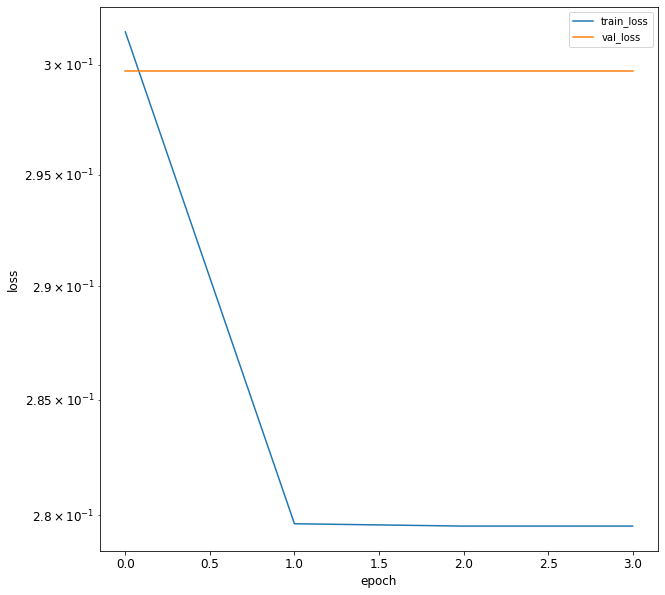

In [53]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

In [ ]:
# Save the weights
path = '/content/drive/MyDrive/Machine Learning Models/FYP/CNN1/'
model.save_weights(path)

# Import pre-trained weights

In [ ]:
path = '/content/drive/MyDrive/Machine Learning Models/FYP/CNN1/'
# Create a new model instance
model = create_model()
# Restore the weights
model.load_weights(path)

# Testing on the same turbine

In [ ]:
# demonstrate prediction
yhat = model.predict(X_test, verbose=0)

In [ ]:
yhat = yhat.reshape(yhat.shape[0],)
df_final=pd.DataFrame({'y_hat':yhat,'y_test':y_test})

In [ ]:
df_final['difference'] = df_final['y_hat']-df_final['y_test']
df_final["abs_difference"] = abs(df_final['y_hat']-df_final['y_test'])
print(df_final["difference"].mean())
print(df_final["abs_difference"].mean())

In [ ]:
df_final.to_csv('drive/MyDrive/DatasetsWind/df_final.csv', index=False)

# Results, Plots

In [ ]:
# Adding data_time column back
frames = []

for i in range(0,len(split_index),2):
  dfx = df[split_index[i]:split_index[i+1]]

  if i>=len(split_index)*0.8:
    frames.append(dfx.iloc[n_steps-1:,:])

test = pd.concat(frames)
test.drop("Date_Time", axis='columns', inplace=True)
test = test.reset_index()
df_final["Date_Time"] = test["Date_Time"]

In [ ]:
column_name = 'y_test' 
column_name1 = 'y_hat'

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_final['Date_Time'], y=df_final[column_name], mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=df_final['Date_Time'],y=df_final[column_name1], mode='lines', name='Predicted'))
fig.update_layout(title_text= "Actual vs Predicted")

fig.show()

In [ ]:
column_name = 'difference' 

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_final['Date_Time'], y=df_final[column_name], mode='lines', name='Error'))
fig.update_layout(title_text= "Error")

fig.show()

In [ ]:
column_name = 'abs_difference' 

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_final['Date_Time'], y=df_final[column_name], mode='lines', name='Absolute Error'))
fig.update_layout(title_text= "Absolute Error")

fig.show()

Re-sampling data

In [ ]:
#@title Resampling { display-mode: "form" }
sample_frequency = 60 #@param {type:"slider", min:20, max:120, step:10}
sample = str(sample_frequency) + "min"

In [ ]:
df_final['Date_Time'] = pd.to_datetime(df_final['Date_Time'], format="%Y-%m-%d %H:%M:%S")
df_final.set_index('Date_Time', inplace = True)
df_resample = df_final.resample(sample).mean().reset_index()
df_final = df_final.reset_index()

In [ ]:
df_final

In [ ]:
column_name = 'difference' 

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_resample['Date_Time'], y=df_resample[column_name], mode='lines', name='Error'))
fig.update_layout(title_text= "Error")

fig.show()

In [ ]:
column_name = 'abs_difference' 

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_resample['Date_Time'], y=df_resample[column_name], mode='lines', name='Absolute Error'))
fig.update_layout(title_text= "Absolute Error")

fig.show()